In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
import torch.autograd as autograd
import torchtext.vocab as torchvocab
from torch.autograd import Variable
import numpy as np
import tqdm
import os
import time
import re
import pandas as pd
import string
import gensim
import time
import random
import collections
from collections import Counter
from nltk.corpus import stopwords
from itertools import chain
from sklearn import manifold
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
wvmodel=gensim.models.Word2Vec.load("weibomodel").wv

In [178]:
data=pd.read_csv("yqdata.csv",usecols=['cut','fact','opinion','inhibition','fff',
                                      'activation','moral'])

In [179]:
x_data=data['cut'].values.tolist()

In [144]:
y_data=data['activation'].values.tolist()
labels = len(set(y_data))

In [180]:
def del_zero(x):
    return x-1

tmp_data=data[data['activation']!=0]
tmp_data['label']=tmp_data['activation'].apply(del_zero)
x_data=tmp_data['cut'].values.tolist()
y_data=tmp_data['label'].values.tolist()
labels = len(set(y_data))    

D:\anaconda\envs\HW0\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [181]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_data,
                                               y_data,test_size=0.20,random_state=1)

In [7]:
vocab = set(chain(*x_data))
vocab_size = len(vocab)
print(vocab_size)

2526


In [8]:
len(list(chain(*x_data)))

288151

# 切词长度288151，实际上只有2526个词汇

In [51]:
embed_size = 100
num_hiddens = 64
num_layers = 2
bidirectional = True
batch_size = 32
lr = 0.001
device = torch.device('cuda:0')
use_gpu = True

In [13]:
word_to_idx = {word: i+1 for i, word in enumerate(vocab)}
word_to_idx['<unk>'] = 0
idx_to_word = {i+1: word for i, word in enumerate(vocab)}
idx_to_word[0] = '<unk>'

In [14]:
weight = torch.zeros(vocab_size+1, embed_size)
for i in range(len(wvmodel.index2word)):
    try:
        index = word_to_idx[wvmodel.index2word[i]]
    except:
        continue
    weight[index, :] = torch.from_numpy(wvmodel.get_vector(
        idx_to_word[word_to_idx[wvmodel.index2word[i]]]))

D:\anaconda\envs\HW0\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  


In [15]:
def encode_samples(tokenized_samples):
    features = []
    for sample in tokenized_samples:
        feature = []
        for token in sample:
            if token in word_to_idx:
                feature.append(word_to_idx[token])
            else:
                feature.append(0)
        features.append(feature)
    return features

In [16]:
def pad_samples(features, maxlen, PAD=0):
    padded_features = []
    for feature in features:
        if len(feature) >= maxlen:
            padded_feature = feature[:maxlen]
        else:
            padded_feature = feature
            while(len(padded_feature) < maxlen):
                padded_feature.append(PAD)
        padded_features.append(padded_feature)
    return padded_features

In [182]:
MAX=20
train_features = torch.tensor(pad_samples(encode_samples(x_train),maxlen=MAX))
train_labels = torch.tensor(y_train,dtype=torch.int64)
test_features = torch.tensor(pad_samples(encode_samples(x_test),maxlen=MAX))
test_labels = torch.tensor(y_test,dtype=torch.int64)

In [183]:
train_set = torch.utils.data.TensorDataset(train_features, train_labels)
test_set = torch.utils.data.TensorDataset(test_features, test_labels)
train_iter = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True)
test_iter = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                        shuffle=False)

In [184]:
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 bidirectional, weight, labels, use_gpu, **kwargs):
        super(SentimentNet, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.use_gpu = use_gpu
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.embedding.weight.requires_grad = True
        self.encoder = nn.LSTM(input_size=embed_size, hidden_size=self.num_hiddens,
                               num_layers=num_layers, bidirectional=self.bidirectional,
                               dropout=0)
        if self.bidirectional:
            self.FC1 = nn.Linear(num_hiddens * 4, num_hiddens)
        else:
            self.FC1 = nn.Linear(num_hiddens * 2, num_hiddens)
        
        self.decoder=nn.Sequential(
            nn.Dropout(p=0.5),nn.ReLU(),nn.Linear(num_hiddens,labels))

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        states, hidden = self.encoder(embeddings.permute([1, 0, 2]))
        encoding = torch.cat([states[0], states[-1]], dim=1)
        tmp = self.FC1(encoding)
        outputs=self.decoder(tmp)
        
        return outputs,embeddings

In [162]:
class textCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, seq_len, labels, weight, **kwargs):
        super(textCNN, self).__init__(**kwargs)
        self.labels = labels
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.embedding.weight.requires_grad = False
        self.conv1 = nn.Conv2d(1, 1, (2, embed_size))
        self.conv2 = nn.Conv2d(1, 1, (3, embed_size))
        self.conv3 = nn.Conv2d(1, 1, (4, embed_size))
        self.pool1 = nn.MaxPool2d((seq_len - 2 + 1, 1))
        self.pool2 = nn.MaxPool2d((seq_len - 3 + 1, 1))
        self.pool3 = nn.MaxPool2d((seq_len - 4 + 1, 1))
        self.linear = nn.Linear(3, labels)

    def forward(self, inputs):
        inputs = self.embedding(inputs).view(inputs.shape[0], 1, inputs.shape[1], -1)
        x1 = F.relu(self.conv1(inputs))
        x2 = F.relu(self.conv2(inputs))
        x3 = F.relu(self.conv3(inputs))

        x1 = self.pool1(x1)
        x2 = self.pool2(x2)
        x3 = self.pool3(x3)

        x = torch.cat((x1, x2, x3), -1)
        x = x.view(inputs.shape[0], 1, -1)

        x = self.linear(x)
        x = x.view(-1, self.labels)

        return(x)

In [163]:
#net = textCNN(vocab_size=(vocab_size+1), embed_size=embed_size,
#              seq_len=MAX, labels=labels, weight=weight)
#net.to(device)
#loss_function = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=lr)

In [185]:
model = SentimentNet(vocab_size=(vocab_size+1), embed_size=embed_size,
                   num_hiddens=num_hiddens, num_layers=num_layers,
                   bidirectional=bidirectional, weight=weight,
                   labels=labels, use_gpu=use_gpu)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [186]:
def category_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.max(preds,1)[1]
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        batch = tuple(t.to(device) for t in batch)
        vectors,labels=batch
        
        optimizer.zero_grad()
        
        predictions,embeddings = model(vectors)
        
        loss = criterion(predictions, labels)
        
        acc = category_accuracy(predictions, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator),epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            batch = tuple(t.to(device) for t in batch)
            vectors,labels=batch

            predictions,embeddings = model(vectors)
            
            loss = criterion(predictions, labels)
            
            acc = category_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [187]:
N_EPOCHS = 20

best_valid_loss = float('inf')
trainacc,val_acc,trainloss,val_loss=[],[],[],[]

for epoch in range(N_EPOCHS):
    
    start = time.time()
    
    train_loss,train_acc= train(model, train_iter, optimizer, criterion)
    valid_loss,valid_acc = evaluate(model, test_iter, criterion)
        
    end = time.time()
        
    runtime = end - start
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lstm-model.pt')
    trainacc.append(train_acc)
    val_acc.append(valid_acc)
    trainloss.append(train_loss)
    val_loss.append(valid_loss)
    #print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print('epoch: %d, train loss: %.4f, train acc: %.4f, test loss: %.4f, test acc: %.4f, time: %.2f' %
      (epoch, train_loss, train_acc, valid_loss,valid_acc, runtime))

epoch: 0, train loss: 0.9174, train acc: 0.5752, test loss: 0.9109, test acc: 0.5715, time: 0.53
epoch: 1, train loss: 0.8211, train acc: 0.6454, test loss: 0.8829, test acc: 0.5715, time: 0.61
epoch: 2, train loss: 0.8097, train acc: 0.6558, test loss: 0.9027, test acc: 0.5715, time: 0.55
epoch: 3, train loss: 0.7815, train acc: 0.6572, test loss: 0.8420, test acc: 0.5715, time: 0.62
epoch: 4, train loss: 0.7465, train acc: 0.6603, test loss: 0.8266, test acc: 0.5767, time: 0.56
epoch: 5, train loss: 0.7360, train acc: 0.6671, test loss: 0.8303, test acc: 0.5767, time: 0.61
epoch: 6, train loss: 0.6973, train acc: 0.6703, test loss: 0.8102, test acc: 0.5767, time: 0.61
epoch: 7, train loss: 0.6803, train acc: 0.6753, test loss: 0.8222, test acc: 0.5767, time: 0.60
epoch: 8, train loss: 0.6235, train acc: 0.6784, test loss: 0.8083, test acc: 0.5743, time: 0.55
epoch: 9, train loss: 0.5040, train acc: 0.7708, test loss: 0.9224, test acc: 0.5743, time: 0.57
epoch: 10, train loss: 0.4551,

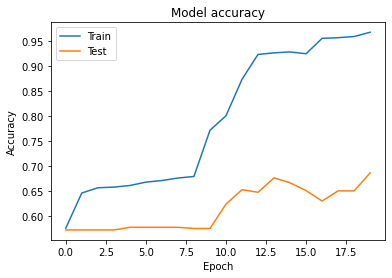

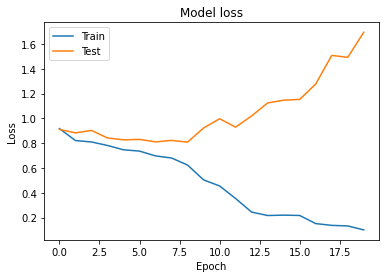

In [188]:
import matplotlib.pyplot as plt
# 绘制训练 
plt.plot(trainacc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(trainloss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [189]:
def get_feature(model, iterator,labels):
    model.eval()
    labels=labels
    with torch.no_grad():
        
        origin=torch.zeros([1,MAX*embed_size],dtype=torch.float)
        output=torch.zeros([1,labels],dtype=torch.float)
        label=torch.zeros([1],dtype=torch.int64)
        tmp_origin=origin
        tmp_output=output
        for batch in iterator:
            batch = tuple(t.to(device) for t in batch)
            vectors,label_list=batch
            predictions,embeddings = model(vectors)
            embedding=embeddings.view(embeddings.size()[0],embeddings.size()[1]*embeddings.size()[2])
            tmp_output=torch.cat((tmp_output,predictions.cpu().data),0)
            tmp_origin=torch.cat((tmp_origin,embedding.cpu().data),0)
            #print(label_list.size())
            label=torch.cat((label,label_list.cpu().data),0)
    return tmp_origin,tmp_output,label

model.load_state_dict(torch.load('lstm-model.pt'))
begin,end,label=get_feature(model,test_iter,labels)

In [190]:
X=end.numpy()[1:,]

Y=label.numpy()[1:,]

In [191]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)

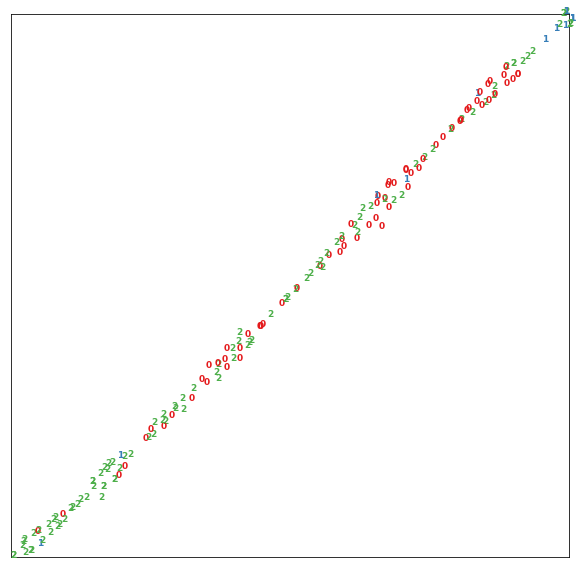

In [192]:
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(10, 10))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(Y[i]), color=plt.cm.Set1(Y[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()